In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
import geopandas
import numpy as np
import shap
import torch.nn.functional as F
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer

from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
from torch import nn
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split, StaticGraphTemporalSignalBatch

from torch_geometric_temporal.nn.attention.stgcn import STConv
from torch_geometric_temporal.nn.recurrent.temporalgcn import TGCN

from tqdm import tqdm
from torch.nn import PoissonNLLLoss
import time

import mlflow
from mlflow.models.signature import infer_signature
import os
import random

### Setup MLflow

In [5]:
tracking_uri = os.environ['MLFLOW_TRACKING_URI']
mlflow.set_tracking_uri(tracking_uri)

mlflow.set_experiment("rides_forecasting")

<Experiment: artifact_location='s3://mlflowbucket21465/mlruns/8', creation_time=1755215676532, experiment_id='8', last_update_time=1755215676532, lifecycle_stage='active', name='rides_forecasting', tags={}>

### Retrieve weather data

In [40]:
from meteostat import Point, Daily, Hourly
from datetime import datetime

start = datetime(2020, 1, 1)
end = datetime(2023, 2, 1)
location = Point(41.8667, -87.6, 181)

In [41]:
data = Hourly(location, start, end)
data = data.fetch()

In [42]:
data.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-01-31 20:00:00,-10.6,-21.0,42.0,0.0,<NA>,280.0,14.8,<NA>,1030.5,<NA>,1.0
2023-01-31 21:00:00,-10.6,-21.0,42.0,0.0,<NA>,280.0,14.8,<NA>,1029.8,<NA>,2.0
2023-01-31 22:00:00,-10.6,-22.1,38.0,0.0,<NA>,290.0,13.0,<NA>,1030.0,<NA>,1.0
2023-01-31 23:00:00,-11.1,-22.0,40.0,0.0,<NA>,270.0,14.8,<NA>,1030.4,<NA>,1.0
2023-02-01 00:00:00,-12.2,-22.2,43.0,0.0,<NA>,260.0,11.2,<NA>,1030.8,<NA>,1.0


In [43]:
data.to_csv("./weatherdata/weather.csv")

In [6]:
weather = pd.read_csv("./weatherdata/weather.csv")

In [13]:
weather.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2020-01-01 00:00:00,-2.0,-6.0,74.0,NaN,NaN,280.0,24.0,NaN,1009.8,NaN,3.0
1,2020-01-01 01:00:00,-1.7,-6.1,72.0,0.0,NaN,280.0,24.1,NaN,1011.0,NaN,4.0
2,2020-01-01 02:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,20.5,NaN,1011.3,NaN,4.0
3,2020-01-01 03:00:00,-1.7,-5.5,75.0,0.0,NaN,260.0,27.7,NaN,1011.1,NaN,3.0
4,2020-01-01 04:00:00,-1.7,-5.5,75.0,0.0,NaN,270.0,14.8,NaN,1011.1,NaN,3.0


In [14]:
weather.tail()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
27044,2023-01-31 20:00:00,-10.6,-21.0,42.0,0.0,NaN,280.0,14.8,NaN,1030.5,NaN,1.0
27045,2023-01-31 21:00:00,-10.6,-21.0,42.0,0.0,NaN,280.0,14.8,NaN,1029.8,NaN,2.0
27046,2023-01-31 22:00:00,-10.6,-22.1,38.0,0.0,NaN,290.0,13.0,NaN,1030.0,NaN,1.0
27047,2023-01-31 23:00:00,-11.1,-22.0,40.0,0.0,NaN,270.0,14.8,NaN,1030.4,NaN,1.0
27048,2023-02-01 00:00:00,-12.2,-22.2,43.0,0.0,NaN,260.0,11.2,NaN,1030.8,NaN,1.0


In [7]:
weather = weather.dropna(axis=1, thresh=0.8*weather.shape[0])

In [8]:
weather.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27049 entries, 0 to 27048
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    27049 non-null  object 
 1   temp    27049 non-null  float64
 2   dwpt    27049 non-null  float64
 3   rhum    27049 non-null  float64
 4   prcp    26646 non-null  float64
 5   wdir    27049 non-null  float64
 6   wspd    27049 non-null  float64
 7   pres    27049 non-null  float64
 8   coco    26799 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.9+ MB


In [9]:
weather['time'] = pd.to_datetime(weather['time'])

In [10]:
weather.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27049 entries, 0 to 27048
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    27049 non-null  datetime64[ns]
 1   temp    27049 non-null  float64       
 2   dwpt    27049 non-null  float64       
 3   rhum    27049 non-null  float64       
 4   prcp    26646 non-null  float64       
 5   wdir    27049 non-null  float64       
 6   wspd    27049 non-null  float64       
 7   pres    27049 non-null  float64       
 8   coco    26799 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 1.9 MB


Lag the weather data since it is hourly and to avoid data leakage when we combine with the 30 minute interval ride data

In [11]:
cols_to_lag = weather.columns.drop("time")

for col in cols_to_lag:
    weather[col] = weather[col].shift(-1)

In [12]:
weather.to_csv("weather_features.csv", index=False)

### Connect to duckdb

In [13]:
conn = duckdb.connect("rides.ddb")

In [ ]:
# Run after done running cells
conn.close()

In [14]:
def fetch_df_from_query(query):
    return conn.execute(query).fetch_df()

### Get Chicago community data

In [15]:
chicago = geopandas.read_file('https://data.cityofchicago.org/resource/igwz-8jzy.geojson')
chicago = chicago.to_crs('EPSG:4326')

# Construct Adjacency matrix

In [9]:
def count_trips_per_group(group):
    query = f"""
    SELECT {group}, COUNT(trip_id) as num_trips
    FROM RIDES_EXTRA_VARS 
    GROUP BY {group}
    """
    count_per_group = conn.execute(query)\
        .fetch_df()\
        .sort_values(by="num_trips", ascending=False)\
        .set_index(group)\

    return count_per_group

count_by_pickup_community_area = count_trips_per_group("pickup_community_area")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [36]:
count_by_pickup_community_area

,num_trips
pickup_community_area,
8.0,20596874
NaN,12610963
28.0,10459624
32.0,10201041
6.0,9164986
...,...
37.0,135898
74.0,131410
52.0,97713


Save so we we don't need to use duckdb again

In [96]:
count_by_pickup_community_area.to_csv("count_by_pickup_community_area.csv")

In [137]:
count_by_pickup_community_area = pd.read_csv("count_by_pickup_community_area.csv",index_col=0)

In [138]:
def remove_decimal(x):
    if x:
        x = x.replace(".0", "")
    return x

def convert_community_area_to_int(df):
    df['pickup_community_area'] = (
        df['pickup_community_area']\
            .astype(str)\
            .apply(lambda x: remove_decimal(x))
    )
    return df

count_by_pickup_community_area_geo = convert_community_area_to_int(count_by_pickup_community_area.reset_index())

# Merge with the Chicago geo data
count_by_pickup_community_area_geo = count_by_pickup_community_area_geo.merge(
    chicago, 
    left_on="pickup_community_area", 
    right_on="area_num_1"
)

In [139]:
count_by_pickup_community_area_geodf = geopandas.GeoDataFrame(count_by_pickup_community_area_geo, geometry="geometry")

In [140]:
count_by_pickup_community_area_geodf["pickup_community_area"] = count_by_pickup_community_area_geodf["pickup_community_area"].astype(int)

In [141]:
count_by_pickup_community_area_geodf = count_by_pickup_community_area_geodf.sort_values(by="pickup_community_area")
count_by_pickup_community_area_geodf["pickup_community_area"] = count_by_pickup_community_area_geodf["pickup_community_area"].astype('str')
count_by_pickup_community_area_geodf = count_by_pickup_community_area_geodf.reset_index(drop=True)

### Adjaceny matrix based on overlap of community borders

In [183]:
n = count_by_pickup_community_area_geodf.shape[0]
A = np.zeros((n, n))

sindex = count_by_pickup_community_area_geodf.sindex

for i, geom in enumerate(count_by_pickup_community_area_geodf.geometry):
    possible_matches_idx = list(sindex.intersection(geom.bounds))
    for j in possible_matches_idx:
        if i != j:
            geom_j = count_by_pickup_community_area_geodf.loc[j, 'geometry']
            if geom.touches(geom_j):
                shared_border = geom.intersection(geom_j).length
                A[i, j] = shared_border

### Adjaceny matrix based on distance of community centroids (This method was used)

In [142]:
n = count_by_pickup_community_area_geodf.shape[0]
A = np.zeros((n, n))

sindex = count_by_pickup_community_area_geodf.sindex

for i, geom in enumerate(count_by_pickup_community_area_geodf.geometry):
    possible_matches_idx = list(sindex.intersection(geom.bounds))
    for j in possible_matches_idx:
        if i != j:
            geom_j = count_by_pickup_community_area_geodf.loc[j, 'geometry']
            if geom.touches(geom_j):
                geom_centroid = geom_j.centroid
                dist = geom.centroid.distance(geom_centroid)
                A[i, j] = dist

In [9]:
A[0,:]

array([0.        , 0.02611732, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
A.size

5929

### Row stadardize

In [143]:
def row_standardize(X:np.ndarray):
    return X / X.sum(axis=1)

In [144]:
A = row_standardize(A)

In [32]:
np.save("adjacency_matrix_distance.npy", A)

### Edge DF

In [33]:
def create_edge_df(data):
    data_ = data.copy()
    data_['geometry_buffer'] = data_.geometry.buffer(0.001)
    buffers = data_.set_geometry('geometry_buffer')

    join = geopandas.sjoin(buffers, data_, how='inner', predicate='intersects')

    edges_df = join[join.index != join['index_right']]
    edges_df = edges_df[['area_num_1_left', 'pickup_community_area_right']].astype(int)

    return edges_df

In [34]:
edges_df = create_edge_df(count_by_pickup_community_area_geodf)

C:\Users\armym\AppData\Local\Temp\ipykernel_32516\1892840954.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_['geometry_buffer'] = data_.geometry.buffer(0.001)


In [35]:
edges_np = edges_df.to_numpy()

In [36]:
edges_np = edges_np - 1

In [37]:
edges_np

array([[ 0, 76],
       [ 0,  1],
       [ 1,  3],
       [ 1, 76],
       [ 1,  0],
       [ 1, 12],
       [ 2,  4],
       [ 2,  5],
       [ 2,  3],
       [ 2, 76],
       [ 3,  4],
       [ 3, 15],
       [ 3, 13],
       [ 3,  5],
       [ 3,  2],
       [ 3, 76],
       [ 3,  1],
       [ 3, 12],
       [ 4,  6],
       [ 4, 21],
       [ 4, 20],
       [ 4, 15],
       [ 4, 13],
       [ 4,  5],
       [ 4,  2],
       [ 4,  3],
       [ 5,  6],
       [ 5,  4],
       [ 5,  2],
       [ 5,  3],
       [ 6,  7],
       [ 6, 23],
       [ 6, 21],
       [ 6,  4],
       [ 6,  5],
       [ 7, 31],
       [ 7, 27],
       [ 7, 23],
       [ 7,  6],
       [ 8,  9],
       [ 9, 75],
       [ 9, 10],
       [ 9, 11],
       [ 9,  8],
       [10, 14],
       [10,  9],
       [10, 11],
       [11, 15],
       [11, 14],
       [11, 13],
       [11, 10],
       [11, 12],
       [11,  9],
       [12, 13],
       [12,  3],
       [12,  1],
       [12, 11],
       [13,  4],
       [13, 15

In [192]:
edges_np[0]

array([ 0, 76])

In [32]:
np.save("edges.npy", edges_np)

In [38]:
edge_weights = []
for i, edge in enumerate(edges_np):
    node_num = edge[0] - 1
    idx = edge[1] - 1 # idx range starts at 1
    weight = A[node_num, idx]
    edge_weights.append(weight)

edge_weights = np.array(edge_weights)

In [20]:
edge_weights

array([0.        , 0.4776777 , 0.        , 0.        , 0.2216943 ,
       0.        , 0.10064059, 0.        , 0.        , 0.        ,
       0.12098201, 0.        , 0.        , 0.12202684, 0.        ,
       0.        , 0.        , 0.        , 0.37971431, 0.        ,
       0.        , 0.        , 0.30182441, 0.10135362, 0.2245661 ,
       0.29977345, 0.24126154, 0.10130394, 0.        , 0.30221418,
       0.12691886, 0.        , 0.        , 0.16196871, 0.10296158,
       0.        , 0.        , 0.        , 0.19345468, 0.        ,
       0.        , 0.1268696 , 0.        , 0.        , 0.        ,
       1.        , 0.41818605, 0.09931836, 0.        , 0.        ,
       0.16945292, 0.0823262 , 0.        , 0.29545178, 0.        ,
       0.        , 0.25160263, 0.135855  , 0.        , 0.0796803 ,
       0.        , 0.15076696, 0.        , 0.        , 0.        ,
       0.06074595, 0.16865327, 0.12789846, 0.        , 0.        ,
       0.        , 0.12167536, 0.        , 0.17477753, 0.22399

In [31]:
np.save("edge_weights.npy", edge_weights)

## Data Prep

In [16]:
query = """ 
 SELECT 
    pickup_community_area,
    time_bucket(INTERVAL '30 minutes', trip_start_timestamp) as interval,
    count(trip_id) as num_rides,
    AVG(fare) as average_fare,
    AVG(trip_total) as average_trip_total,
    MAX(trip_start_day_of_week) as trip_start_day_of_week,
    MAX(trip_start_hour) as trip_start_hour
FROM RIDES_EXTRA_VARS
GROUP BY pickup_community_area, interval
"""

df = fetch_df_from_query(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
df

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour
0,19.0,2021-06-13 23:30:00,17,17.647059,22.392941,0,23
1,34.0,2021-06-13 07:30:00,6,20.000000,24.378333,0,7
2,21.0,2021-06-13 07:30:00,19,17.368421,21.728421,0,7
3,61.0,2021-06-13 06:30:00,8,21.250000,24.582500,0,6
4,77.0,2021-06-13 06:30:00,17,25.625000,34.622500,0,6
...,...,...,...,...,...,...,...
3736457,77.0,2021-06-15 10:30:00,38,12.565789,17.982368,2,10
3736458,5.0,2021-06-15 10:30:00,30,14.250000,18.495667,2,10
3736459,40.0,2021-06-15 10:30:00,9,13.333333,19.912222,2,10
3736460,29.0,2021-06-15 10:00:00,36,12.083333,15.546944,2,10


In [18]:
df = df.sort_values(by=["interval", "pickup_community_area"])\
    .reset_index(drop=True)

### Make target variable

In [19]:
df['target'] = df['num_rides'].shift(-1)

In [20]:
# Remove the row with a nan target from shifting
df = df.iloc[:-1]

In [21]:
# Number of pickup communities in Chicago
df['pickup_community_area'].nunique()

77

In [22]:
# Na pickup communities are pickups outside of Chicago
df = df[~df["pickup_community_area"].isna()]

In [23]:
# Number unique timestamps for pickups
n_time_steps = df['interval'].nunique()

In [24]:
n_time_steps

49321

In [25]:
df['pickup_community_area'] = df['pickup_community_area'].astype(int)

In [26]:
df = df.dropna()

In [50]:
df.head()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour,target
0,1,2020-03-09 09:30:00,65,13.653846,17.577538,1,9,50.0
1,2,2020-03-09 09:30:00,50,10.750000,14.602800,1,9,120.0
2,3,2020-03-09 09:30:00,120,12.354167,17.035000,1,9,47.0
3,4,2020-03-09 09:30:00,47,11.968085,16.276809,1,9,42.0
4,5,2020-03-09 09:30:00,42,10.595238,15.714048,1,9,274.0


In [27]:
# How="left" since weather data is on hour interval
df = df.merge(weather, left_on="interval", right_on="time", how ="left")

In [28]:
df.shape[0]

3687015

In [29]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687015 entries, 0 to 3687014
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3687015 non-null  int32         
 1   interval                3687015 non-null  datetime64[us]
 2   num_rides               3687015 non-null  int64         
 3   average_fare            3687015 non-null  float64       
 4   average_trip_total      3687015 non-null  float64       
 5   trip_start_day_of_week  3687015 non-null  int64         
 6   trip_start_hour         3687015 non-null  int64         
 7   target                  3687015 non-null  float64       
 8   time                    1843765 non-null  datetime64[ns]
 9   temp                    1843765 non-null  float64       
 10  dwpt                    1843765 non-null  float64       
 11  rhum                    1843765 non-null  float64       
 12  prcp          

In [30]:
df = df.ffill()

In [31]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687015 entries, 0 to 3687014
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3687015 non-null  int32         
 1   interval                3687015 non-null  datetime64[us]
 2   num_rides               3687015 non-null  int64         
 3   average_fare            3687015 non-null  float64       
 4   average_trip_total      3687015 non-null  float64       
 5   trip_start_day_of_week  3687015 non-null  int64         
 6   trip_start_hour         3687015 non-null  int64         
 7   target                  3687015 non-null  float64       
 8   time                    3686939 non-null  datetime64[ns]
 9   temp                    3686939 non-null  float64       
 10  dwpt                    3686939 non-null  float64       
 11  rhum                    3686939 non-null  float64       
 12  prcp          

In [32]:
df.head()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour,target,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
0,1,2020-03-09 09:30:00,65,13.653846,17.577538,1,9,50.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2020-03-09 09:30:00,50,10.750000,14.602800,1,9,120.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2020-03-09 09:30:00,120,12.354167,17.035000,1,9,47.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2020-03-09 09:30:00,47,11.968085,16.276809,1,9,42.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2020-03-09 09:30:00,42,10.595238,15.714048,1,9,274.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since df starts at 2020-03-09 09:30:00 and weather is on an hourly interval, we cannot fill the first 75 rows of weather data in df so we just drop these rows.

In [57]:
weather[weather.time.dt.month==3]

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
1440,2020-03-01 00:00:00,0.6,-8.4,51.0,0.0,190.0,13.0,1022.1,2.0
1441,2020-03-01 01:00:00,-0.6,-6.8,63.0,0.0,190.0,11.2,1021.9,2.0
1442,2020-03-01 02:00:00,-1.1,-6.6,66.0,0.0,180.0,14.8,1021.2,2.0
1443,2020-03-01 03:00:00,-1.1,-6.6,66.0,0.0,180.0,7.6,1020.6,2.0
1444,2020-03-01 04:00:00,-1.1,-6.1,69.0,0.0,190.0,11.2,1020.2,2.0
...,...,...,...,...,...,...,...,...,...
19699,2022-03-31 19:00:00,3.9,-1.1,70.0,0.0,320.0,18.4,1000.4,14.0
19700,2022-03-31 20:00:00,3.3,-1.1,73.0,0.0,300.0,20.5,1001.3,12.0
19701,2022-03-31 21:00:00,2.8,-0.7,78.0,0.2,310.0,14.8,1002.3,4.0
19702,2022-03-31 22:00:00,3.3,-1.6,70.0,0.1,310.0,14.8,1003.4,4.0


In [33]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687015 entries, 0 to 3687014
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3687015 non-null  int32         
 1   interval                3687015 non-null  datetime64[us]
 2   num_rides               3687015 non-null  int64         
 3   average_fare            3687015 non-null  float64       
 4   average_trip_total      3687015 non-null  float64       
 5   trip_start_day_of_week  3687015 non-null  int64         
 6   trip_start_hour         3687015 non-null  int64         
 7   target                  3687015 non-null  float64       
 8   time                    3686939 non-null  datetime64[ns]
 9   temp                    3686939 non-null  float64       
 10  dwpt                    3686939 non-null  float64       
 11  rhum                    3686939 non-null  float64       
 12  prcp          

In [34]:
df.iloc[:77].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   pickup_community_area   77 non-null     int32         
 1   interval                77 non-null     datetime64[us]
 2   num_rides               77 non-null     int64         
 3   average_fare            77 non-null     float64       
 4   average_trip_total      77 non-null     float64       
 5   trip_start_day_of_week  77 non-null     int64         
 6   trip_start_hour         77 non-null     int64         
 7   target                  77 non-null     float64       
 8   time                    1 non-null      datetime64[ns]
 9   temp                    1 non-null      float64       
 10  dwpt                    1 non-null      float64       
 11  rhum                    1 non-null      float64       
 12  prcp                    1 non-null      float64     

In [35]:
df = df.dropna()

In [36]:
df = df.drop("time", axis=1)

In [37]:
df.tail()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,trip_start_day_of_week,trip_start_hour,target,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
3687010,73,2022-12-31 23:30:00,34,13.823529,17.145882,6,23,11.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0
3687011,74,2022-12-31 23:30:00,11,8.636364,14.539091,6,23,22.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0
3687012,75,2022-12-31 23:30:00,22,14.886364,18.453182,6,23,60.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0
3687013,76,2022-12-31 23:30:00,60,25.583333,37.202833,6,23,104.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0
3687014,77,2022-12-31 23:30:00,104,11.009615,14.938846,6,23,366.0,2.0,-1.3,79.0,0.0,121.0,6.0,1013.0,3.0


In [38]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3686939 entries, 76 to 3687014
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   pickup_community_area   3686939 non-null  int32         
 1   interval                3686939 non-null  datetime64[us]
 2   num_rides               3686939 non-null  int64         
 3   average_fare            3686939 non-null  float64       
 4   average_trip_total      3686939 non-null  float64       
 5   trip_start_day_of_week  3686939 non-null  int64         
 6   trip_start_hour         3686939 non-null  int64         
 7   target                  3686939 non-null  float64       
 8   temp                    3686939 non-null  float64       
 9   dwpt                    3686939 non-null  float64       
 10  rhum                    3686939 non-null  float64       
 11  prcp                    3686939 non-null  float64       
 12  wdir              

### Preserve cyclical nature of hour and day of week

In [39]:
def cyclical_transform(x, period):
    return np.sin(2 * np.pi * x / period), np.cos(2 * np.pi * x / period)

In [40]:
df['trip_start_hour_sin'] = df['trip_start_hour'].apply(lambda x: cyclical_transform(x, 24)[0])
df['trip_start_hour_cos'] = df['trip_start_hour'].apply(lambda x: cyclical_transform(x, 24)[1])

df['trip_start_day_of_week_sin'] = df['trip_start_day_of_week'].apply(lambda x: cyclical_transform(x, 7)[0])
df['trip_start_day_of_week_cos'] = df['trip_start_day_of_week'].apply(lambda x: cyclical_transform(x, 7)[1])

In [41]:
df = df.drop(['trip_start_hour', 'trip_start_day_of_week'], axis=1)

In [42]:
groups = ['interval']
graph_ts = df.groupby(groups)[df.columns.drop(groups)]
community_areas = set(df['pickup_community_area'].unique())

In [69]:
community_areas = set(df['pickup_community_area'].unique())

In [70]:
df_diff = df.copy()

In [71]:
df_diff['prcp'] = df_diff['prcp'].diff()

In [72]:
df_diff = df_diff.dropna()

In [50]:
df.columns

Index(['pickup_community_area', 'interval', 'num_rides', 'average_fare',
       'average_trip_total', 'target', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir',
       'wspd', 'pres', 'coco', 'trip_start_hour_sin', 'trip_start_hour_cos',
       'trip_start_day_of_week_sin', 'trip_start_day_of_week_cos'],
      dtype='object')

### Create Feature and Target Lists

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, shuffle=False, test_size=0.2)
train, validation = train_test_split(train, shuffle=False, test_size=0.2)

In [75]:
train.tail()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,target,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos
2359712,10,2021-12-29 15:30:00,18,15.833333,20.693333,10.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359713,11,2021-12-29 15:30:00,10,25.000000,30.907000,5.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359714,12,2021-12-29 15:30:00,5,11.500000,17.512000,13.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359715,13,2021-12-29 15:30:00,13,10.961538,14.480000,33.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359716,14,2021-12-29 15:30:00,33,12.500000,16.505152,31.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969


In [69]:
validation.head()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,target,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos
2359717,15,2021-12-29 15:30:00,31,13.416667,17.194333,40.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359718,16,2021-12-29 15:30:00,40,11.000000,15.182750,15.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359719,17,2021-12-29 15:30:00,15,12.500000,16.714667,3.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359720,18,2021-12-29 15:30:00,3,10.833333,12.886667,36.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969
2359721,19,2021-12-29 15:30:00,36,12.013889,15.138056,15.0,1.7,-2.8,72.0,0.0,290.0,11.2,1014.9,4.0,-0.707107,-0.707107,0.433884,-0.900969


In [74]:
df.corr()

,pickup_community_area,interval,num_rides,average_fare,average_trip_total,target,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos
pickup_community_area,1.000000,-0.000060,-0.212458,0.133716,0.126171,-0.145666,-0.000303,-0.000495,-0.000313,-0.000120,0.000461,0.000764,0.000253,-0.000139,-0.004165,-0.005612,-0.000808,0.000026
interval,-0.000060,1.000000,0.110885,0.218598,0.246629,0.114057,-0.027981,-0.048538,-0.065092,-0.013526,0.048138,0.043580,-0.004262,-0.183063,0.002548,0.001690,-0.003547,0.000706
num_rides,-0.212458,0.110885,1.000000,0.120622,0.137398,0.267852,0.017660,-0.002399,-0.047473,-0.001881,0.008291,0.037768,0.003707,-0.014076,-0.131796,-0.060920,-0.065855,0.014728
average_fare,0.133716,0.218598,0.120622,1.000000,0.965537,0.010135,0.079136,0.065746,-0.038983,0.007137,-0.019559,-0.008785,-0.026906,-0.039920,0.076832,0.016833,-0.082244,0.053032
average_trip_total,0.126171,0.246629,0.137398,0.965537,1.000000,0.009859,0.090945,0.082320,-0.029008,0.007553,-0.021444,-0.018975,-0.035299,-0.046735,0.103823,0.012004,-0.071083,0.041007
target,-0.145666,0.114057,0.267852,0.010135,0.009859,1.000000,0.018166,-0.001378,-0.046439,-0.002097,0.008593,0.036531,0.003645,-0.015102,-0.129537,-0.066065,-0.064879,0.013296
temp,-0.000303,-0.027981,0.017660,0.079136,0.090945,0.018166,1.000000,0.913835,-0.240043,0.019493,-0.168037,-0.043123,-0.415296,-0.052058,-0.155443,0.093930,0.017502,-0.024220
dwpt,-0.000495,-0.048538,-0.002399,0.065746,0.082320,-0.001378,0.913835,1.000000,0.166666,0.093630,-0.203310,-0.126886,-0.489365,0.047578,0.005882,0.006295,0.024462,-0.030983
rhum,-0.000313,-0.065092,-0.047473,-0.038983,-0.029008,-0.046439,-0.240043,0.166666,1.000000,0.201412,-0.079137,-0.191332,-0.188580,0.276322,0.375688,-0.209504,0.011555,-0.017923
prcp,-0.000120,-0.013526,-0.001881,0.007137,0.007553,-0.002097,0.019493,0.093630,0.201412,1.000000,-0.020734,0.040115,-0.121843,0.215689,0.005096,0.019913,-0.001392,0.002405


### Cross correlation

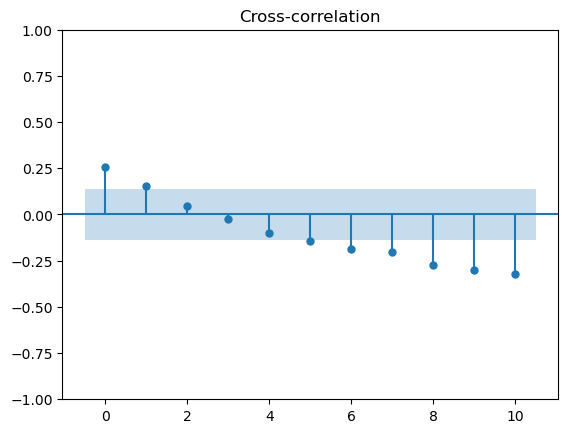

In [75]:
community_area = 1

variable = 'average_trip_total'

df_comm_area = df[df['pickup_community_area'] == community_area].iloc[:200]
ccf = plot_ccf(df_comm_area[variable], df_comm_area['target'], lags=10)

In [89]:
def get_shap_values(df, community):
    from xgboost import XGBRegressor
    df_com = df[df['pickup_community_area'] == community]
    train_com_X = df_com.drop(["target", "pickup_community_area"], axis=1)
    train_com_X = train_com_X.set_index("interval")
    train_com_y = df_com['target']

    xgb = XGBRegressor()

    xgb.fit(train_com_X, train_com_y)

    shap.initjs()

    explainer = shap.TreeExplainer(xgb)

    shapvalues = explainer.shap_values(train_com_X)

    return explainer, shapvalues, train_com_X

In [97]:
explainer, shap_vals, X_train = get_shap_values(df, community=33)

In [91]:
X_train.iloc[:1, :]

,num_rides,average_fare,average_trip_total,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,trip_start_hour_sin,trip_start_hour_cos,trip_start_day_of_week_sin,trip_start_day_of_week_cos
interval,,,,,,,,,,,,,,,
2020-03-09 10:00:00,728,8.818681,14.28647,12.8,0.5,43.0,0.0,220.0,33.5,1018.7,7.0,0.5,-0.866025,0.781831,0.62349


In [94]:
i = 1
shap.force_plot(explainer.expected_value, shap_vals[:i, :], X_train.iloc[:i, :])

In [102]:
abs(shap_vals.mean(axis=0))

array([0.31431603, 0.04296153, 0.33500034, 0.01934302, 0.15359424,
       0.13570929, 0.0768806 , 0.02689067, 0.0057361 , 0.00642523,
       0.07691751, 0.31032118, 0.5072262 , 0.15820877, 0.01820135],
      dtype=float32)

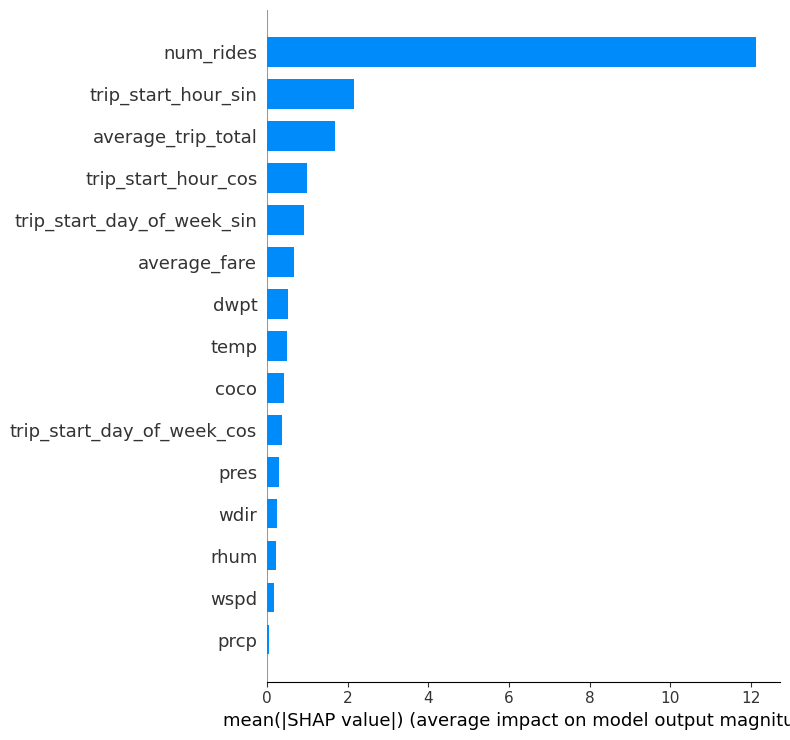

In [106]:
explainer, shap_vals, X_train = get_shap_values(df, community=3)
shap.summary_plot(shap_vals, X_train, plot_type="bar")

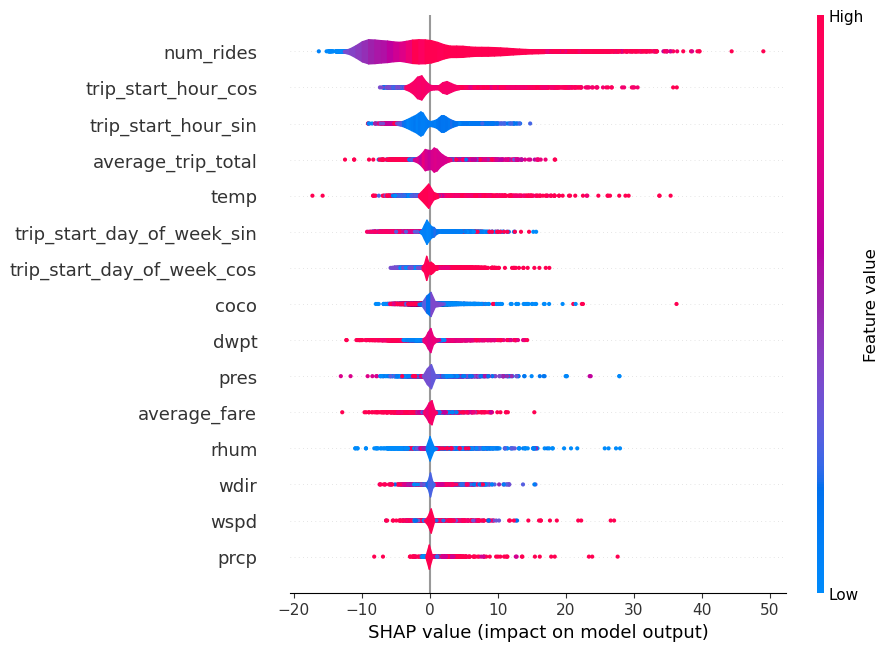

In [104]:
shap.violin_plot(shap_vals, X_train)

In [60]:
df.columns

Index(['pickup_community_area', 'interval', 'num_rides', 'average_fare',
       'average_trip_total', 'target', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir',
       'wspd', 'pres', 'coco', 'trip_start_hour_sin', 'trip_start_hour_cos',
       'trip_start_day_of_week_sin', 'trip_start_day_of_week_cos'],
      dtype='object')

In [109]:
def fit_prophet_models(train, validation, columns):
    
    rename = {"interval": "ds", "target": "y"}
    train = train.rename(rename, axis=1)
    validation = validation.rename(rename, axis=1)

    models_per_community = {}
    
    for com in list(community_areas):
        train_com = train[train["pickup_community_area"] == com].sort_values(by='ds')
        
        val_com = validation[validation["pickup_community_area"] == com].sort_values(by='ds')
        n_val = val_com.shape[0]
        
        
        df_train = train_com[columns + ['y', 'ds']]
        
        df_val = val_com[columns + ['y', 'ds']]
        
        model = Prophet(changepoint_prior_scale=0.01)

        for col in columns:
            model.add_regressor(col)

        model.add_country_holidays(country_name='US')
        model.fit(df_train)

        y_hat = model.predict(df_val)['yhat']
        
        mse = mean_squared_error(df_val['y'], y_hat)
        
        models_per_community[com] = {
            "model": model, 
            "mse": mse,
            "sample_size": df_val.shape[0]
        }
    return models_per_community

In [ ]:
columns = [
        "num_rides", "average_trip_total",
        "trip_start_hour_sin",
        "trip_start_hour_cos",
        "trip_start_day_of_week_sin", 
        "trip_start_day_of_week_cos", 
        "temp"]

models = fit_prophet_models(train, validation, columns=columns)


In [ ]:
models

In [75]:
from typing import Any

def log_performance(models:dict[dict[str, Any]], model_name, model_logger,
                    predictors):
    run_name = f"{model_name}_" + str(random.randint(1000, 9999999))

    with mlflow.start_run(run_name=run_name) as run:
        mse_total = 0
        for community, item in models.items():
            mse_total += item['mse']
            model_logger(
                item['model'], 
                artifact_path=f"{model_name}_{community}"
            )

        total_mse = mse_total / len(models)
        mlflow.log_metric("total_mse", value=total_mse)
        mlflow.log_param("features", value=predictors)
        
        item.pop("model")
        mlflow.log_dict(item, artifact_file=f"{community}_metrics")

        print(mse_total)

In [ ]:
log_performance(models, model_name="prophet_models", 
                model_logger=mlflow.prophet.log_model, predictors=columns)

### Check if target satisfies requirements for ARIMA

In [63]:
train_com1 = train[train["pickup_community_area"] == 4].set_index('interval')['target']

<Axes: ylabel='Frequency'>

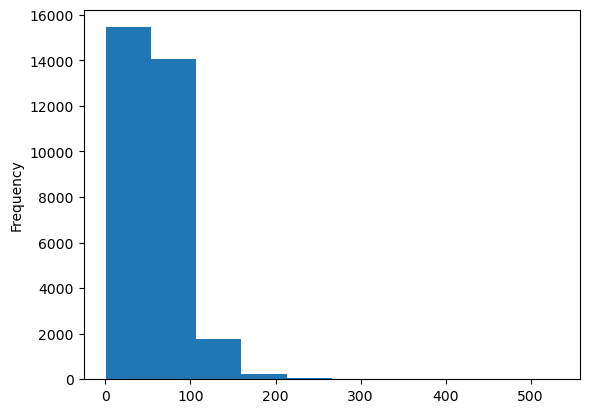

In [183]:
train_com1.plot(kind='hist')

In [184]:
print(train_com1.mean())
print(train_com1.var())

55.44657274022479
1243.5568671320648


<Axes: xlabel='interval'>

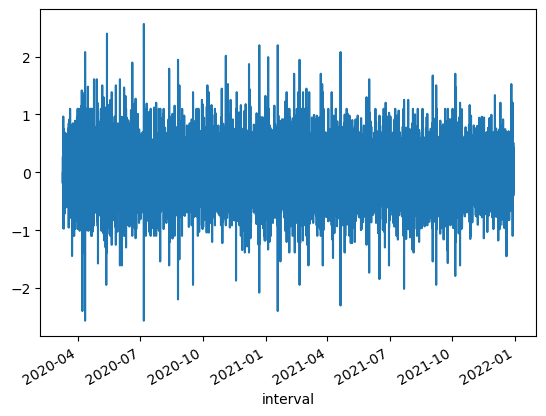

In [185]:
np.log(train_com1).diff().plot()

In [111]:
from statsmodels.tsa.stattools import adfuller
adfuller(
    x=np.log(train_com1).diff().dropna()
)


(-37.47021733426273,
 0.0,
 51,
 31631,
 {'1%': -3.4305567538415263,
  '5%': -2.861631379782367,
  '10%': -2.5668186386394765},
 -42552.361547452936)

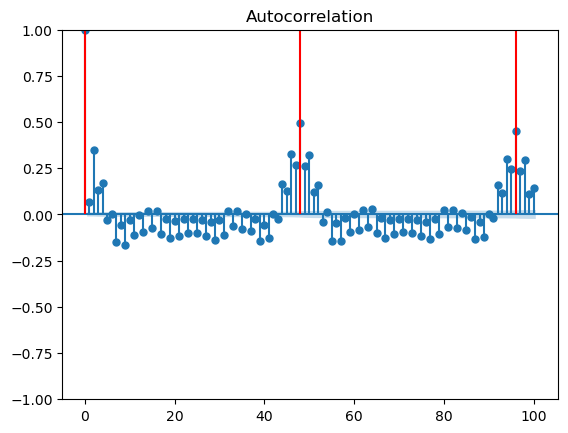

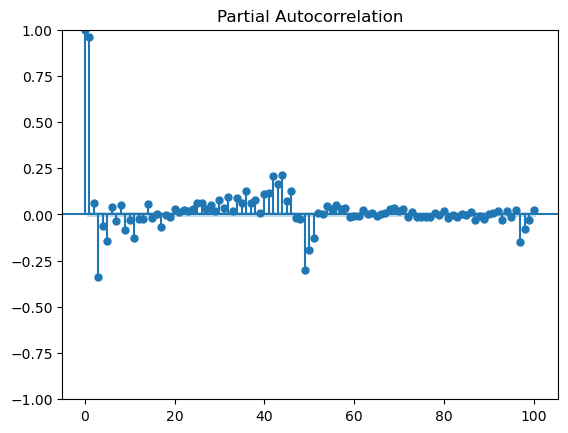

In [112]:
acf_plot = plot_acf(np.log(train_com1).diff().dropna(), lags = 100)
for i in range(0, 3):
    plt.vlines(x=i*48, ymin=0, ymax=1, color='red')

pacf = plot_pacf(train_com1, lags = 100)

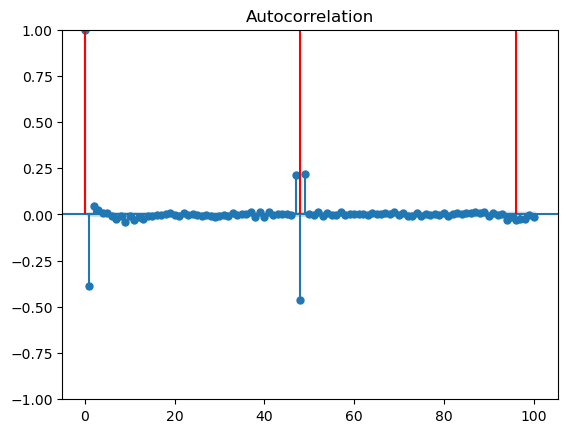

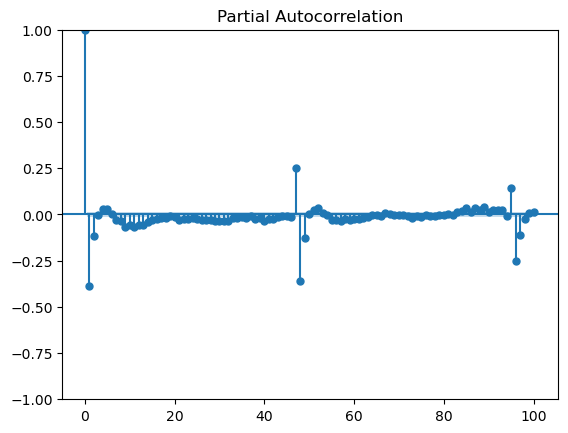

In [113]:
train_com1_seas_diff = np.log(train_com1).diff().dropna().diff(48).dropna()
acf_plot = plot_acf(train_com1_seas_diff, lags = 100)
for i in range(0, 3):
    plt.vlines(x=i*48, ymin=0, ymax=1, color='red')

pacf = plot_pacf(train_com1_seas_diff, lags = 100)

### Verify stationarity of variables for ARIMA

<Axes: xlabel='interval'>

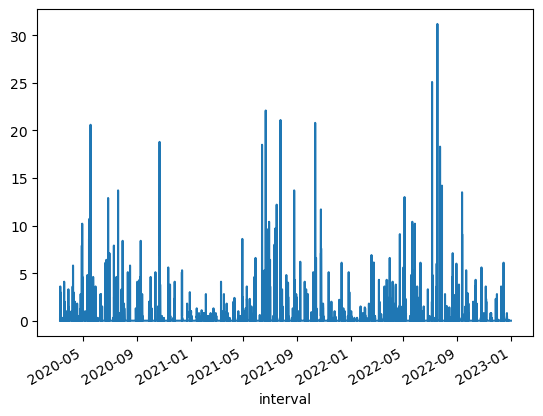

In [56]:
comm_8 = df[df['pickup_community_area'] == 8].set_index("interval")
comm_8["prcp"].plot()

In [62]:
comm_8_diff = comm_8.diff()

<Axes: xlabel='interval'>

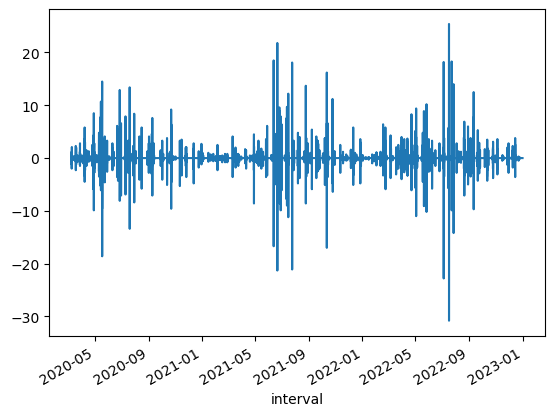

In [63]:
#differenced
comm_8_diff["prcp"].plot()

<Axes: xlabel='interval'>

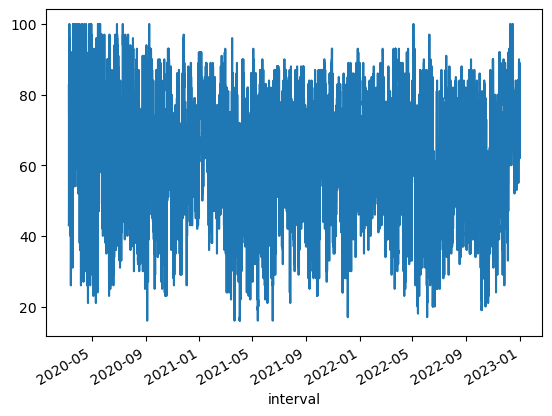

In [68]:
comm_8["rhum"].plot()

<Axes: xlabel='interval'>

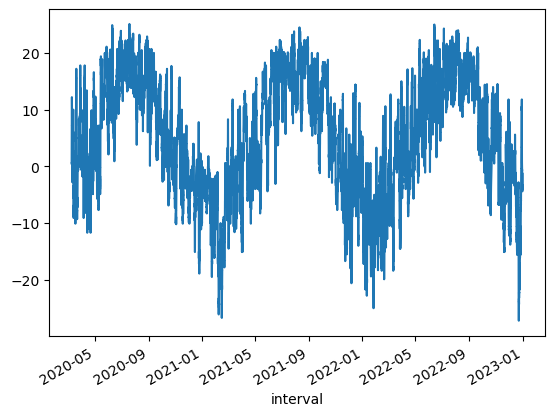

In [69]:
comm_8["dwpt"].plot()

<Axes: xlabel='interval'>

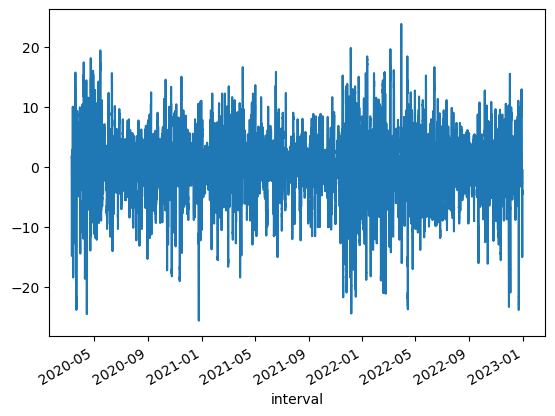

In [70]:
comm_8.diff(48)["dwpt"].plot()

<Axes: xlabel='interval'>

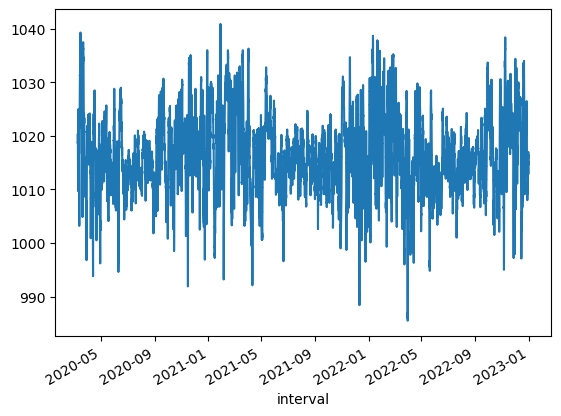

In [71]:
comm_8["pres"].plot()

<Axes: xlabel='interval'>

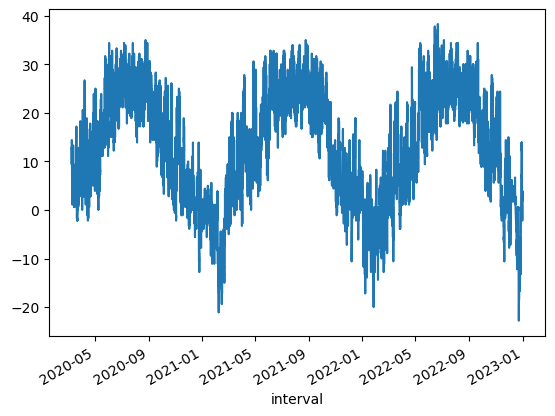

In [58]:
comm_8["temp"].plot()

<Axes: xlabel='interval'>

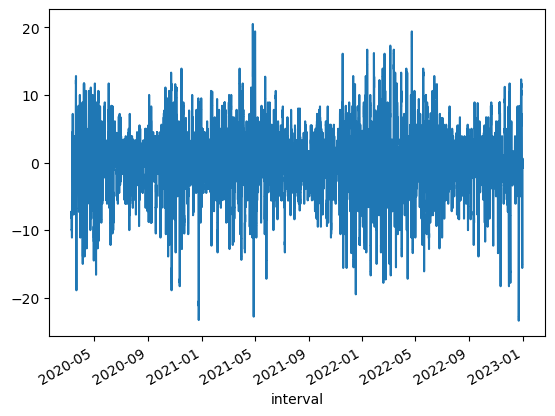

In [59]:
# Seasonal difference temperature
comm_8["temp"].diff(48).plot()

<Axes: xlabel='interval'>

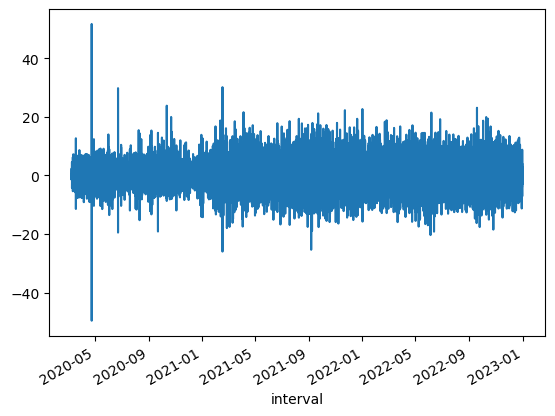

In [54]:
comm_8["average_trip_total"].diff().plot()

In [510]:
df_diff['num_rides'].shift(1)

76           NaN
77          89.0
78          68.0
79         156.0
80          68.0
           ...  
3687010      8.0
3687011     34.0
3687012     11.0
3687013     22.0
3687014     60.0
Name: num_rides, Length: 3686939, dtype: float64

In [540]:
# Add differenced variables
df_diff = df.copy()

# add some laggs of num_rides
for lag in range(1, 10):
    df_diff[f'num_rides_diff{lag}'] = df_diff['num_rides'].shift(lag)


diffs = pd.DataFrame()

for key, val in df_diff.groupby(["pickup_community_area"]):
    diff = val.copy()
    diff["temp"] = diff["temp"].diff(48)
    diff['average_fare'] = diff['average_fare'].diff()
    diff['average_trip_total'] = diff['average_trip_total'].diff()
    diff["dwpt"] = diff["dwpt"].diff(48)
    diffs = pd.concat([diffs, diff], axis=0)

diffs = diffs.dropna()


In [74]:
train_diff, test_diff = train_test_split(diffs, shuffle=False, test_size=0.2)
train_diff, validation_diff = train_test_split(train, shuffle=False, test_size=0.2)

In [77]:
def fit_arima_models(train, validation, columns):
    
    train = train.set_index("interval")[-100000:]
    validation = validation.set_index("interval")

    train.index.freq = pd.infer_freq(train.index)
    validation.index.freq = pd.infer_freq(validation.index)

    models_per_community = {}
    
    for com in list(community_areas):
        train_com = train[train["pickup_community_area"] == com]
        val_com = validation[validation["pickup_community_area"] == com]
        n_val = val_com.shape[0]

        y = np.log(train_com['target'])
        X = train_com[columns]
        X_val = val_com[columns]
        
        
        y_val = val_com['target']

        model = AutoARIMA(
            max_p=3, 
            max_q=3,
            start_P=0,
            start_Q=0,
            d=1,
            max_D=1,
            max_P=1,
            max_Q=1,
            n_jobs=4,
        )

        model.fit(y=y, X=X)

        fh = ForecastingHorizon(pd.date_range(start=y.index[-1] + pd.Timedelta(minutes=30),
                                      periods=len(X_val), freq="30T"),
                        is_relative=False)
        
        y_hat = model.predict(fh=fh, X=X_val)

        mse = mean_squared_error(y_val, np.exp(y_hat))
        
        models_per_community[com] = {
            "model": model, 
            "mse": mse,
            "sample_size": X_val.shape[0]
        }
    return models_per_community

In [78]:
df.columns

Index(['pickup_community_area', 'interval', 'num_rides', 'average_fare',
       'average_trip_total', 'target', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir',
       'wspd', 'pres', 'coco', 'trip_start_hour_sin', 'trip_start_hour_cos',
       'trip_start_day_of_week_sin', 'trip_start_day_of_week_cos'],
      dtype='object')

In [78]:
predictors = [
        "average_trip_total",
        "trip_start_hour_sin",
        "trip_start_hour_cos",
        "trip_start_day_of_week_sin", 
        "trip_start_day_of_week_cos", 
        "temp"]
models = fit_arima_models(train_diff, validation_diff, 
                          predictors)

# Note: autoarima was tested with sp=48 but was too computationally intensive
# The last 100000 of train data values were sampled to speed up computation

c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
c:\Users\armym\anaconda3\envs\Fresh\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Li

In [80]:
models

{1: {'model': AutoARIMA(d=1, max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=4, start_P=0,
            start_Q=0),
  'mse': 234.03902272357982,
  'sample_size': 7858},
 2: {'model': AutoARIMA(d=1, max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=4, start_P=0,
            start_Q=0),
  'mse': 7678.396824101059,
  'sample_size': 7857},
 3: {'model': AutoARIMA(d=1, max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=4, start_P=0,
            start_Q=0),
  'mse': 460.8160571781098,
  'sample_size': 7858},
 4: {'model': AutoARIMA(d=1, max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=4, start_P=0,
            start_Q=0),
  'mse': 869.8582784789072,
  'sample_size': 7854},
 5: {'model': AutoARIMA(d=1, max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=4, start_P=0,
            start_Q=0),
  'mse': 32435.994757107044,
  'sample_size': 7852},
 6: {'model': AutoARIMA(d=1, max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=4, start_P=0,
            start_Q=0),
  'mse': 21968.49945534748,
  'sample_size': 7858},
 7: {'model': AutoARIMA(d=

In [211]:
models[1]['model'].get_fitted_params()

{'average_fare': 0.0010186675147909642,
 'trip_start_day_of_week': -0.013039475306898213,
 'ma.L1': -0.32994113022769467,
 'ma.L2': 0.06362032269500631,
 'ma.L3': 0.039654602583621835,
 'sigma2': 0.017046212128103824,
 'order': (0, 1, 3),
 'seasonal_order': (0, 1, 0, 48),
 'aic': -1575.890746139543,
 'aicc': -1575.825121139543,
 'bic': -1544.9303308939661,
 'hqic': -1564.2685103780482}

In [79]:
from sktime.utils import mlflow_sktime
log_performance(models, model_name="ARIMA", model_logger=mlflow_sktime.log_model,
                predictors=predictors)

2025/08/18 16:45:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/18 16:45:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/18 16:45:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/18 16:45:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/18 16:46:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/18 16:46:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/18 16:46:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use 

848714.4005328959
🏃 View run ARIMA_3133222 at: http://10.0.0.3:5000/#/experiments/8/runs/b66130dcd4954d0391b1109926b5c647
🧪 View experiment at: http://10.0.0.3:5000/#/experiments/8


In [129]:
from sklearn import set_config
set_config(transform_output="pandas")

In [130]:
def fit_negative_bin_models(train, validation, continuous_cols:list, descrete_cols:list):
    train = train.set_index("interval")
    validation = validation.set_index("interval")

    continuous_cols = continuous_cols + ['pickup_community_area', 'target']
    transformer = ColumnTransformer(
        [("continuous_transform", FunctionTransformer(lambda x: x), continuous_cols),
         ("descrete_transform", OneHotEncoder(sparse_output=False), descrete_cols)
         ],
         verbose_feature_names_out=False
    )

    train = transformer.fit_transform(train)
    validation = transformer.transform(validation)

    columns = list(train.columns.drop(["target", "pickup_community_area"]))

    models_per_community = {}
    
    for com in list(community_areas):
        train_com = train[train["pickup_community_area"] == com].copy()
        val_com = validation[validation["pickup_community_area"] == com].copy()
        
        lagged_var_names = []
        for i in range(1, 3):
            name = f'target_lagged_{i}'
            lagged_var_names.append(name)
            train_com.loc[:, name] = train_com['target'].shift(i)
            val_com.loc[:, name]  = val_com['target'].shift(i)

        train_com = train_com.dropna()
        val_com = val_com.dropna()


        train_X = sm.add_constant(train_com[columns + lagged_var_names])

        val_X = sm.add_constant(val_com[columns + lagged_var_names])


        model = Poisson(
            endog=train_com['target'], 
            exog=train_X
        )

        fit = model.fit()

        y_hat = fit.predict(val_X)

        mse = mean_squared_error(val_com['target'], y_hat)
        
        models_per_community[com] = {
            "model": fit, 
            "mse": mse,
            "sample_size": val_com.shape[0]
        }
    return models_per_community

In [131]:
models = fit_negative_bin_models(train, validation, continuous_cols=predictors, descrete_cols=[])

Optimization terminated successfully.
         Current function value: 3.481081
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.956654
         Iterations 6
Optimization terminated successfully.
         Current function value: 3.628431
         Iterations 6
Optimization terminated successfully.
         Current function value: 4.029220
         Iterations 7
Optimization terminated successfully.
         Current function value: 13.531995
         Iterations 6
Optimization terminated successfully.
         Current function value: 12.662857
         Iterations 6
Optimization terminated successfully.
         Current function value: 24.095439
         Iterations 7
Optimization terminated successfully.
         Current function value: 2.294401
         Iterations 7
Optimization terminated successfully.
         Current function value: 2.845992
         Iterations 7
Optimization terminated successfully.
         Current function value: 2.656510

In [ ]:
models

{1: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34f83e50>,
  'mse': 114.99588948053314,
  'sample_size': 7856},
 2: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34fa2510>,
  'mse': 3163.62205587859,
  'sample_size': 7855},
 3: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34f4a7d0>,
  'mse': 422.8770188066128,
  'sample_size': 7856},
 4: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34cdce90>,
  'mse': 520.4827442573859,
  'sample_size': 7852},
 5: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34dfa8d0>,
  'mse': 13107.982330955881,
  'sample_size': 7850},
 6: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34dfaa90>,
  'mse': 23927.342849320135,
  'sample_size': 7856},
 7: {'model': <statsmodels.discrete.discrete_model.PoissonResultsWrapper at 0x18a34df88d0>,
  'mse': 229794.5575160472,
  'sample_size

In [198]:
len(models)

77

In [199]:
fourth_com = models[4]

In [200]:
fourth_com["model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                 target   No. Observations:                31583
Model:               NegativeBinomial   Df Residuals:                    31578
Method:                           MLE   Df Model:                            4
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                  0.1372
Time:                        14:00:13   Log-Likelihood:            -1.3303e+05
converged:                       True   LL-Null:                   -1.5418e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.7531      0.008    358.368      0.000       2.738       2.768
average_fare               0.0082      0.000     16.974      0.000       0.007       0.009
trip_start_day_of_week    -0.0118      0.001    -11.622      0.000      -0.014      -0.010
target_lagged_1            0.0142      0.000     88.903      0.000       0.014       0.014
target_lagged_2            0.0043      0.000     27.590      0.000       0.004       0.005
alpha                      0.1016      0.001     98.245      0.000       0.100       0.104
==========================================================================================
"""

In [ ]:
log_performance(models, model_name="Poisson", model_logger=mlflow.statsmodels,
                predictors=predictors)

4019.94019715967

In [ ]:
processed_data_path = "./data/processed_data.csv"
df.to_csv(processed_data_path)

In [ ]:
df = pd.read_csv(processed_data_path, index_col=0)

### Prepare data for spatial AR

In [541]:
multi_index = pd.MultiIndex.from_frame(diffs[["pickup_community_area", "interval"]])

In [542]:
df_multi = diffs.copy()
df_multi.index = multi_index

In [543]:
communities = df_multi.index.get_level_values(0).unique()
time_stamps = df_multi.index.get_level_values(1).unique()
full_index = pd.MultiIndex.from_product(
        [communities, time_stamps], names=["pickup_community_area", "interval"]
)

In [544]:
df_multi = df_multi.reindex(full_index)

In [545]:
df_multi = df_multi.drop(["pickup_community_area", "interval"], axis=1)

In [546]:
df_multi['target'] = df_multi['target'].fillna(0)

In [547]:
df_multi = df_multi.ffill()

In [548]:
df_multi.isna().any().any()

False

In [549]:
df_multi.head()

num_rides  average_fare  \
pickup_community_area interval                                       
1                     2020-03-10 10:00:00       77.0     -2.026391   
                      2020-03-10 10:30:00       72.0      1.251353   
                      2020-03-10 11:00:00       75.0     -0.137500   
                      2020-03-10 11:30:00       79.0      0.075527   
                      2020-03-10 12:00:00       57.0      0.527981   

                                           average_trip_total  target  temp  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00           -2.120764    59.0 -10.0   
                      2020-03-10 10:30:00            1.105622    67.0 -10.0   
                      2020-03-10 11:00:00            0.392750    54.0  -7.2   
                      2020-03-10 11:30:00           -0.281384    59.0  -7.2   
                      2020-03-10 12:00:00            1.137735    55.0  -7.2   

                                           dwpt  rhum  prcp   wdir  wspd  ...  \
pickup_community_area interval                                            ...   
1                     2020-03-10 10:00:00   1.7  96.0   0.0   20.0  22.3  ...   
                      2020-03-10 10:30:00   1.7  96.0   0.0   20.0  22.3  ...   
                      2020-03-10 11:00:00  -2.2  96.0   0.0  360.0  16.6  ...   
                      2020-03-10 11:30:00  -2.2  96.0   0.0  360.0  16.6  ...   
                      2020-03-10 12:00:00  -6.1  89.0   0.0  330.0  20.5  ...   

                                           trip_start_day_of_week_cos  \
pickup_community_area interval                                          
1                     2020-03-10 10:00:00                   -0.222521   
                      2020-03-10 10:30:00                   -0.222521   
                      2020-03-10 11:00:00                   -0.222521   
                      2020-03-10 11:30:00                   -0.222521   
                      2020-03-10 12:00:00                   -0.222521   

                                           num_rides_diff1  num_rides_diff2  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00            120.0            233.0   
                      2020-03-10 10:30:00            102.0            121.0   
                      2020-03-10 11:00:00            106.0            166.0   
                      2020-03-10 11:30:00             73.0            254.0   
                      2020-03-10 12:00:00             93.0            121.0   

                                           num_rides_diff3  num_rides_diff4  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00             13.0              2.0   
                      2020-03-10 10:30:00             13.0              3.0   
                      2020-03-10 11:00:00             12.0              2.0   
                      2020-03-10 11:30:00             13.0              5.0   
                      2020-03-10 12:00:00             18.0              4.0   

                                           num_rides_diff5  num_rides_diff6  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00             24.0              8.0   
                      2020-03-10 10:30:00             25.0             10.0   
                      2020-03-10 11:00:00             24.0              7.0   
                      2020-03-10 11:30:00             16.0              6.0   
                      2020-03-10 12:00:00             22.0             11.0   

                                           num_rides_diff7  num_rides_diff8  \
pickup_community_area interval                                                
1                     2020-03-10 10:00:00             47.0             30.0   
                   

In [550]:
df_multi_flat = df_multi.reset_index()

In [551]:
n_intervals = int(df_multi_flat.shape[0]*0.8 // 77)

In [552]:
df_multi_flat.shape[0]*0.8

3035155.2

In [553]:
39417*77

3035109

In [554]:
train = df_multi_flat.sort_values(['interval', 'pickup_community_area']).iloc[:n_intervals*77]
test = df_multi_flat.sort_values(['interval', 'pickup_community_area']).iloc[n_intervals*77:]

In [555]:
n_intervals = int(train.shape[0]*0.8 // 77)

validation = train.sort_values(['interval', 'pickup_community_area']).iloc[n_intervals*77:]
train = train.sort_values(['interval', 'pickup_community_area']).iloc[:n_intervals*77]

### Gather latest 1000 samples for each community due to Panel_FE_Lag being memory intensive

In [ ]:
train_size = 2000
train_subset = train.groupby(["pickup_community_area"]).tail(train_size)
val_subset = validation

In [574]:
predictors = ['num_rides',
              'average_trip_total',
 'trip_start_hour_sin',
 'trip_start_hour_cos',
 'trip_start_day_of_week_sin',
 'trip_start_day_of_week_cos',
 'temp'
 ]

In [575]:
x = train_subset[predictors].values

In [576]:
x_val = val_subset[predictors].values

In [577]:
x = x.reshape(-1, len(predictors))
x_val = x_val.reshape(-1, len(predictors))

In [578]:
y = train_subset['target'].values.reshape(-1,1)
y_val = val_subset['target'].values.reshape(-1,1)

In [579]:
y.shape

(154000, 1)

In [580]:
x.shape

(154000, 7)

In [581]:
from spreg import Panel_FE_Lag
import libpysal

w = libpysal.weights.full2W(A)

model = Panel_FE_Lag(y, x, w=w, name_y='rides')

In [582]:
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG PANEL - FIXED EFFECTS
-----------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       rides                Number of Observations:      154000
Mean dependent var  :      0.0000                Number of Variables   :           8
S.D. dependent var  :     62.7456                Degrees of Freedom    :      153992
Pseudo R-squared    :      0.1881
Spatial Pseudo R-squared:  0.1751
Sigma-square ML     :    3199.186                Log likelihood        :-1760659.548
S.E of regression   :      56.561                Akaike info criterion : 3521335.096
                                                 Schwarz criterion     : 3521414.654

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------

In [592]:
train_mse = (model.u**2).mean()
train_mse

3199.1860877983445

In [590]:
y_last = y[-77:]
X_new = x_val[:77]

In [591]:
model.rho

0.24222703565930365

In [588]:
# Recover fixed effects
fe = model.u.reshape(-1, 77).mean(axis=0)

In [ ]:
run_name = "spatialAR_" + str(random.randint(1000, 9999999))
with mlflow.start_run() as run:
    rho = model.rho
    beta = model.betas.flatten()[:-1] 


    W_array = w.full()[0]
    errors = []

    ones = np.ones(shape=(77, 1))
    for key, val in val_subset.groupby(["interval"]):
        # Predict next period
        X_new = val[predictors].values
        try:
            y_pred = (rho * W_array @ y_last) + X_new @ beta.reshape(-1, 1) + fe.reshape(-1, 1)
            y_last = y_pred
            
            error = y_pred - val['target'].to_numpy().reshape(-1,1) 
            errors.extend(error.tolist())
        except ValueError as e:
            print(e)

    mse = (np.array(error)**2).mean()
    print(mse)
    mlflow.log_metric("mse", mse)
    mlflow.log_param("predictors", predictors)
    mlflow.log_metric("train_size", train_size)

14094.38800121588
🏃 View run invincible-whale-822 at: http://10.0.0.3:5000/#/experiments/8/runs/a13da35d7b0549d39ed4ff1588e4b958
🧪 View experiment at: http://10.0.0.3:5000/#/experiments/8


### Prepare data for spatio-temporal graph neural networks

In [113]:
groups = ['interval']
graph_ts = df.groupby(groups)[df.columns.drop(groups)]
community_areas = set(df['pickup_community_area'].unique())

In [114]:
weather_features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres',
       'coco']

In [115]:
def fill_absent_communities(X):
    missing_com = community_areas - set(X['pickup_community_area'])

    day_of_week_sin = X["trip_start_day_of_week_sin"].iat[0]
    day_of_week_cos = X["trip_start_day_of_week_cos"].iat[0]

    hour_sin = X["trip_start_hour_sin"].iat[0]
    hour_cos = X["trip_start_hour_cos"].iat[0]

    def fill_val(val=None):
        if val:
            return [val for com in missing_com]
    
        return [0 for com in missing_com]
    
    columns = X.columns.drop(
        ["pickup_community_area",
         "trip_start_day_of_week_sin",
         "trip_start_day_of_week_cos",
         "trip_start_hour_sin",
         "trip_start_hour_cos"] + weather_features
    )

    data = {
        "pickup_community_area": [com for com in missing_com],
        "trip_start_day_of_week_sin": fill_val(day_of_week_sin),
        "trip_start_day_of_week_cos": fill_val(day_of_week_cos),
        "trip_start_hour_sin": fill_val(hour_sin),
        "trip_start_hour_cos": fill_val(hour_cos)
    }

    # Fill in the weather
    for weather_fet in weather_features:
        data.update({weather_fet: fill_val(X[weather_fet].iloc[-1])})
    
    # Fill in other unknown columns with 0
    more_data = {
        col: fill_val() for col in columns
    }

    data.update(more_data)
        
    new_df = pd.DataFrame(data)

    # Make sure oickup communities always in correct order
    X = pd.concat([X, new_df], axis=0, ignore_index=True)\
        .sort_values(by="pickup_community_area") 
    return X


features = []
targets = []
for g, val in graph_ts:

    val = fill_absent_communities(val)
   
    feat = val.drop(['pickup_community_area', 'target'], axis=1)\
        .to_numpy()

    
    trgts = val['target'].to_numpy()
    
    features.append(feat)
    targets.append(trgts)

In [116]:
len(features)

49320

In [117]:
np.isnan(np.array(features)).any()

False

In [118]:
features[0].shape

(77, 15)

In [119]:
features = np.array(features)

In [13]:
test_data = [
    np.array([[1,2],[1, 2]]),
    np.array([[3,4], [3,4]]),
    np.array([[5,6], [5,6]])
]

In [55]:
test_data

array([[[1, 2],
        [1, 2]],

       [[3, 4],
        [3, 4]],

       [[5, 6],
        [5, 6]]])

In [14]:
np.array(test_data).shape

(3, 2, 2)

In [15]:
test_data = np.array(test_data)

In [120]:
def lag_features_np(features, n_time_steps_back):
    """Reduced memory consumption of this algorithm by 100% by efficiently using numpy"""
    features = np.flip(features, axis=0)
    added_lagged_features = np.empty(
        (
            len(features) - n_time_steps_back, 
            1 + n_time_steps_back, 
            features.shape[1], 
            features.shape[2]
        )
    )
    
    for i, X in enumerate(features[:len(features) - n_time_steps_back]):
        i_old = i
        
        lagged = np.empty(
            (
                n_time_steps_back + 1, 
                features.shape[1], 
                features.shape[2]
            )
        )
        
        i += n_time_steps_back + 1

        
        lagged[0,:,:] = X

        # Loop over n_time_steps previous feature matrices up to current time i
        for j, X_lagged in enumerate(features[i - n_time_steps_back: i]): 
            lagged[j+1,:,:] = X_lagged
    
        
        added_lagged_features[i_old, :, :, :] = lagged
    
    added_lagged_features = np.flip(added_lagged_features, axis=0)
    added_lagged_features = np.flip(added_lagged_features, axis=1)
    
    return added_lagged_features

In [72]:
def lag_features(features, n_time_steps_back):
    added_lagged_features = []
    
    for i, X in enumerate(features[:len(features) - n_time_steps_back]):
        
        i += n_time_steps_back + 1
        #print(i, i - n_time_steps_back + 1, i)
        lagged = [X.tolist()]

        # Loop over n_time_steps previous feature matrices up to current time i
        for X_lagged in features[i - n_time_steps_back: i]:
            #print(X_lagged)
            lagged.append(X_lagged.tolist())
        #assert len(lagged) == n_time_steps_back - 1, i
        added_lagged_features.append(lagged)
    
    return added_lagged_features

In [120]:
lagged= lag_features_np(test_data, 1)

In [121]:
lagged

array([[[[1., 2.],
         [1., 2.]],

        [[3., 4.],
         [3., 4.]]],


       [[[3., 4.],
         [3., 4.]],

        [[5., 6.],
         [5., 6.]]]])

In [68]:
np.array(lagged)

array([[[[3.00e+000, 4.00e+000],
         [3.00e+000, 4.00e+000]],

        [[0.00e+000, 0.00e+000],
         [0.00e+000, 0.00e+000]]],


       [[[5.00e+000, 6.00e+000],
         [5.00e+000, 6.00e+000]],

        [[2.32e-322, 2.57e-322],
         [2.72e-322, 1.28e-322]]]])

In [20]:
np.array(lagged).shape

(1, 3, 2, 2)

In [121]:
n_time_steps_back = 15

In [122]:
added_lagged_features = lag_features_np(features, 15)

In [87]:
added_lagged_features[:1]

array([[[[ 8.90000000e+01,  1.13764045e+01,  1.52259551e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 6.80000000e+01,  1.02205882e+01,  1.32097059e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 1.56000000e+02,  1.03525641e+01,  1.45732692e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         ...,
         [ 8.00000000e+00,  1.46875000e+01,  1.81375000e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 2.96000000e+02,  2.55152027e+01,  3.65071622e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 9.30000000e+01,  1.11559140e+01,  1.56206452e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01]],

        [[ 8.90000000e+01,  1.09831461e+01,  1.46742697e+01, ...,
          -8.66025404e-01,  7.81831482e-01,  6.23489802e-01],
         [ 7.00000000e+01,  1.13928571e+01,  1.47520000e+01, ...,
          -8.66025404e

In [43]:
added_lagged_features.shape

(49305, 16, 77, 15)

In [123]:
n_time_steps = df['interval'].nunique() - n_time_steps_back

In [124]:
n_time_steps

49305

In [125]:
len(added_lagged_features)

49305

In [126]:
edges = [edges_np for i in range(n_time_steps)]

edge_weights_list = [edge_weights for i in range(n_time_steps)]

In [127]:
assert len(edges) == len(added_lagged_features)
assert len(edges) == len(edge_weights_list)
assert len(edges[0]) == len(edge_weights_list[0])

In [128]:
dataset = StaticGraphTemporalSignal(
    edge_index=edges_np.T,
    edge_weight=edge_weights,
    features=added_lagged_features,
    targets=targets[n_time_steps_back:],
) 

In [129]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.80)
train_dataset, validation = temporal_signal_split(train_dataset, train_ratio=0.80)

In [130]:
class TensorStandardizer:
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, x:torch.Tensor, dim: int | tuple):
        self.means = torch.mean(x, dim=dim)
        self.stds = torch.std(x, dim=dim)

    def transform(self, x:torch.Tensor):
        return (x - self.means) / self.stds

    def fit_transform(self, x:torch.Tensor, dim: int | tuple):
        self.fit(x, dim)
        return self.transform(x)
    
    def save_means_stds(self, means_path, stds_path):
        if self.means is not None:
            np.save(means_path, self.means.numpy())

        if self.stds is not None:
            np.save(stds_path, self.means.numpy())

    def load_means_stds(self, means_path, stds_path):
        self.means = torch.tensor(np.load(means_path), dtype=torch.float64)
        self.stds = torch.tensor(np.load(stds_path), dtype=torch.float64)



In [131]:
standardizer = TensorStandardizer()

In [132]:
train_dataset.features.shape

(31555, 16, 77, 15)

### Only standardize non-cyclical data

In [133]:
features_tensor = torch.tensor(train_dataset.features.copy())
# up to 11 continuous variables
train_dataset.features[:,:,:, :11] = standardizer.fit_transform(features_tensor[:,:,:, :11], dim=(0,1))

In [63]:
standardizer.save_means_stds("standardizer_means.npy", "standardizer_stds.npy")

In [134]:
validation.features[:,:,:, :11] = standardizer.transform(torch.tensor(validation.features.copy()[:,:,:, :11]))

In [135]:
test_dataset.features[:,:,:, :11] = standardizer.transform(torch.tensor(test_dataset.features.copy()[:,:,:, :11]))

In [136]:
print(torch.isnan(features_tensor).any())

tensor(False)


In [ ]:
for i, j in enumerate(train_dataset):
    print(j.x.shape)
    print(j.edge_index.shape)
    print(j.edge_index.max())
    print(j.edge_index.min())
    print(j.edge_attr.shape)
    break

In [138]:
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X):
        X = X.permute(0, 3, 1, 2)
        temp = self.conv1(X) + torch.sigmoid(self.conv2(X))
        out = F.relu(temp + self.conv3(X))
        # (batch_size, num_nodes, n_timesteps_out, n_features_out=out_channels)
        out = out.permute(0, 2, 3, 1)
        return out

In [139]:
class SpatialTemporalModel(nn.Module):
    def __init__(self, n_nodes, in_channels, n_time_steps_input, H=1, 
                 kernel_size=3):
        super(SpatialTemporalModel, self).__init__()
        self.H = H
        self.kernel_size = kernel_size
        self.STConv1 = STConv(
            num_nodes=n_nodes,
            in_channels=in_channels,
            hidden_channels=16,
            out_channels=64,
            kernel_size=3,
            K=1
        )

        self.STConv2 = STConv(
            num_nodes=n_nodes,
            in_channels=64,
            hidden_channels=16,
            out_channels=64,
            kernel_size=3,
            K=1
        )

        self.last_temporal = TemporalConv(in_channels=64, out_channels=64)

        linear_size = n_time_steps_input - 2*(2*(self.kernel_size-1)) - self.kernel_size + 1

        self.linear = nn.Linear(linear_size*64, 1)

        self.softplus = nn.Softplus()


    def forward(self, x:torch.Tensor, edge_index, weight_index):
        x = self.STConv1(x, edge_index, weight_index)
        x = self.STConv2(x, edge_index, weight_index)
        
        x = x.permute(0, 2, 1, 3)
        x = self.last_temporal(x)

        x = self.linear(x.reshape((x.shape[0], x.shape[1], -1)))
        x = self.softplus(x)
        return x.squeeze(dim=(0,1))

In [140]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [141]:
device

device(type='cuda', index=0)

In [142]:
from torch.utils.data import Dataset

class TemporalGraphDataset(Dataset):
    def __init__(self, dataset: StaticGraphTemporalSignal):
        self.features = dataset.features.copy()
        self.targets = dataset.targets.copy()
        self.edge_index = torch.tensor(dataset.edge_index.copy(), dtype=torch.long)
        self.edge_attr = torch.tensor(dataset.edge_weight.copy())
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'x': torch.tensor(self.features[idx], dtype=torch.float),
            'y': torch.tensor(self.targets[idx], dtype=torch.float),
            'edge_index': self.edge_index,
            'edge_attr': self.edge_attr
        }
        

In [143]:
train_torch_dataset = TemporalGraphDataset(train_dataset)
validation_torch_dataset = TemporalGraphDataset(validation)
test_torch_dataset = TemporalGraphDataset(test_dataset)

In [144]:
batch_size=64

In [145]:
train_loader = torch.utils.data.DataLoader(train_torch_dataset, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_torch_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_torch_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

print(f"training on {device}")

def train(
        n_features,
        model,
        optimizer,
        train_loader,
        validation_loader,
        saved_model_path,
        checkpoints_path,
        n_epochs=50,
        check_point_interval=10
):
    loss = PoissonNLLLoss(log_input=False)
    mse = nn.MSELoss()

    cost_list, val_cost_list, mse_list, val_mse_list = [], [], [], []

    best_val_loss = 10000000
    best_val_epoch = None
    for epoch in tqdm(range(n_epochs)):
        cost = 0
        mse_total = 0

        for timestamp, snapshot in enumerate(train_loader):
            model.train()
            
            optimizer.zero_grad()

            x = snapshot['x']
            
            n_nodes = x.shape[2]
            n_features = x.shape[-1]
            
            if x.dim() == 2:
                x = x.permute(1,0).unsqueeze(-1)
            
            x = x.view(-1, n_time_steps_back + 1 , n_nodes, n_features)


            edge_index = snapshot['edge_index'][0, :, :]
            edge_attr = snapshot['edge_attr'][0, :]
            
            start = time.time()
            y_hat = model(x, edge_index, edge_attr)

            # Get a time for how fast each forward pass is
            if epoch == 0 and timestamp == 0:
                end = time.time()
                print(f"Elapsed time: {end - start:.4f} seconds")
            
            y = snapshot['y']
            y = y.view(-1, 77, 1).squeeze()
            batch_loss = loss(y_hat.squeeze(), y)
            cost = cost + batch_loss.item()

            mse_batch = mse(y_hat.squeeze(), y)
            mse_total = mse_total + mse_batch.item()
            mse_batch.backward()
            optimizer.step()
        

        with torch.no_grad():
            val_loss = 0
            val_mse_total = 0
            model.eval()
            for timestamp, snapshot in enumerate(validation_loader):
                x = snapshot['x']
                n_nodes = x.shape[1]
                n_features = x.shape[-1]

                if x.dim() == 2:
                    x = x.permute(1,0).unsqueeze(-1)
                
                x = x.view(-1, n_time_steps_back + 1 , 77, n_features)

                y_hat = model(x, edge_index, edge_attr)

                y = snapshot['y']
                y = y.view(-1, 77, 1).squeeze()
                val_batch_loss = loss(y_hat.squeeze(), y)
                
                val_loss = val_loss + val_batch_loss.item()
                val_mse_total += mse(y_hat.squeeze(), y).item()
            
            # Save model if it improves compared to best_val_loss
            if val_mse_total < best_val_loss:
                print("Saving current best model")
                torch.save(model.state_dict(), saved_model_path)
                best_val_loss = val_mse_total
                best_val_epoch = epoch
            
            
            val_cost_list.append(val_loss / (timestamp + 1))
            val_mse_list.append(val_mse_total / (timestamp + 1))
            print(f"val_loss: {val_loss / (timestamp + 1)}")
            print(f"val_mse_total: {val_mse_total / (timestamp + 1)}")

        cost_list.append(cost)
        mse_list.append(mse_total / (timestamp + 1))
        
        # Checkpoint model
        if (epoch + 1) % check_point_interval == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_mse_total
                }, f'{checkpoints_path}/checkpoint_{epoch}_{batch_size}.pth'
            )
            
        #if epoch % 10 ==0:         
        cost = cost / (timestamp + 1)
        print(f"NNL: {cost}")
        print(f"MSE: {mse_total / (timestamp + 1)}")
        
    return cost_list, val_cost_list, mse_list, val_mse_list, best_val_loss, best_val_epoch

training on cuda:0


In [198]:
for i in train_loader:
    print(i['x'][0,:,:,:].squeeze(0).shape)
    input_example = {
        'x': i['x'][0,:,:,:].squeeze(0).numpy().tolist(),
        'edge_index': i['edge_index'][0, :, :].squeeze(0).numpy().tolist(),
        'edge_attr': i['edge_attr'][0, :].squeeze(0).numpy().tolist()
    }
    break

torch.Size([16, 77, 15])


In [ ]:
class GraphModel(mlflow.pyfunc.PythonModel):
    """
    Wraps SpatialTemporalModel into a pyfunc PythonModel
    """
    def __init__(self, model, standardizer):
        self.model = model
        self.model.eval()
        self.standardizer = standardizer

    def predict(self, context, model_input: list[dict], params=None) -> list:
        """
        :param context:
        :param model_input: dict formatted as {
            'x': numpy array shaped (n_time_steps, n_nodes, n_features),
            'edge_index': numpy array of edge indices,
            'edge_attr': numpy array of edge weights
        }
        :param params:
        :return: np.ndarray
        """
        predictions = []
        for item in model_input:
            x = item['x']
            x = torch.tensor(x, dtype=torch.float).unsqueeze(0)
            x = self.standardize(x)
    
            edge_index = torch.tensor(item['edge_index'])
            edge_attr = torch.tensor(item['edge_attr'])
    
            with torch.no_grad():
                out = self.model(x, edge_index, edge_attr)
                predictions.append(out.numpy().tolist())
        return predictions

    def standardize(self, x: torch.Tensor) -> torch.Tensor:
        x[:, :, :, :11] = self.standardizer.transform(x[:, :, :, :11])
        return x

In [ ]:
name = "SpatialTemporalGNN" + str(random.randint(10000, 999999))
with mlflow.start_run(run_name=name) as run:
    n_features = train_dataset.features.shape[-1]
    n_time_steps_input = 16
    
    model = SpatialTemporalModel(
        in_channels=n_features, n_nodes=77, n_time_steps_input=n_time_steps_input
    )

    lr = 0.001
    weight_decay = 1e-4
    n_epochs = 40

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    mlflow.log_params({
        "lr": lr,
        "weight_decay": weight_decay,
        "n_time_steps_input": n_time_steps_input,
        "n_features": n_features,
        "batch_size": batch_size,
        "n_epochs": n_epochs
    })

    losses = train(
        n_features=n_features,
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=validation_loader,
        saved_model_path="models/SpatialTemporalv1.pth",
        checkpoints_path="./model_checkpoints",
        check_point_interval=2,
        n_epochs=n_epochs
    )

    mlflow.log_metrics({
        "BestValidationMSE": losses[-2],
        "BestValidationEpoch": losses[-1]
    })

    mlflow.log_dict({
        "PoissonNLL": losses[0],
        "ValidationPoissonNLL": losses[1],
        "MSE": losses[2],
        "ValidationMSE": losses[3]
    }, "performance.json")

    # Log best model
    best_model = SpatialTemporalModel(in_channels=n_features, n_time_steps_input=16, n_nodes=77)
    best_model.load_state_dict(torch.load("models/SpatialTemporalv1.pth", weights_only=True))

    best_model_pyfunc = GraphModel(model, standardizer)

    out = best_model_pyfunc.predict(context=None, model_input=[input_example])
    
    sig = infer_signature(model_input=[input_example], 
                          model_output=np.array(out[0]))

    mlflow.pyfunc.log_model(
        python_model=best_model_pyfunc, 
        artifact_path="model",
        pip_requirements=[
            "torch==2.6.0",
            "torchvision==0.21.0",
            "torch-geometric==2.6.1",
            "torch_geometric_temporal==0.56.1",
            "torch_sparse==0.6.18",
            "torch_scatter==2.1.2",
            "numpy==1.26.4"
        ],
        signature=sig,
        code_paths=['./src/inference_server/model_code.py']
    )

Since the Spatio-Temporal Graph Convolutional Network has lower validation loss, we choose it and test

In [ ]:
n_features = train_dataset.features.shape[-1]
model2 = SpatialTemporalModel(in_channels=n_features, n_time_steps_input=16, n_nodes=77)
model2.load_state_dict(torch.load("models/SpatialTemporalv1.pth", weights_only=True))

### Testing

In [ ]:
test_mse = 0
loss = PoissonNLLLoss(log_input=False)
mse = nn.MSELoss()
model2.eval()
with torch.no_grad():
    val_loss = 0
    val_mse_total = 0
    for timestamp, snapshot in enumerate(test_dataset):
        n_nodes = snapshot.x.shape[1]
        n_features = snapshot.x.shape[2]
        x = snapshot.x
        
        x = x.unsqueeze(0)
    
        y_hat = model2(x, snapshot.edge_index, snapshot.edge_attr)
        y = snapshot.y
        
        test_mse += mse(y_hat.squeeze(), y)


    print(f"test_mse_total: {test_mse / (timestamp+1)}")